# BERT Fine-Tuning for Classification

## 1. Environment Setup

In [ ]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

CUDA available: True
GPU device: Tesla T4
GPU memory: 15.83 GB


## 2. Dataset Preparation

In [ ]:
# Load the IMDB dataset
from datasets import load_dataset

dataset = load_dataset("imdb")

# Peek at the dataset structure
print(dataset)
print("\nSample data:")
print(dataset["train"][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Sample data:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking p

### Check for Class Imbalance

In [ ]:
# Check class distribution
from collections import Counter
import numpy as np

labels = dataset["train"]["label"]
label_counts = Counter(labels)
print(f"Label distribution: {label_counts}")

# Calculate class weights for balanced training
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
print(f"Class weights: {class_weights}")

Label distribution: Counter({0: 12500, 1: 12500})
Class weights: [1. 1.]


### Tokenization with BERT

In [ ]:
# Initialize the BERT tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize a sample text
sample_text = "I absolutely loved this movie! Highly recommend it."
tokens = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128)

print("Tokenized sample:")
print(tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenized sample:
{'input_ids': [101, 1045, 7078, 3866, 2023, 3185, 999, 3811, 16755, 2009, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Tokenize the entire dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply the tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Inspect tokenized samples
print("Tokenized dataset structure:")
print(tokenized_datasets["train"][0])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenized dataset structure:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nud

## 3. Model Selection and Configuration

In [ ]:
# Initialize a BERT model for binary classification
from transformers import AutoModelForSequenceClassification

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

print("Model configuration:")
print(model.config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model configuration:
BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



### Custom BERT Model with Additional Layers

In [ ]:
# Custom BERT Model with dropout and additional FC layer
import torch.nn as nn

class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output[1])  # Applying dropout
        logits = self.fc(pooled_output)  # Adding a fully connected layer
        return logits

# Initialize the custom model (optional - comment out if using standard model)
# custom_model = CustomBERTModel("bert-base-uncased", num_labels=2)

## 4. Training Pipeline

### Define Training Arguments

In [ ]:
# Define training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="steps",     # Evaluate at the end of each epoch
    save_strategy="steps",
    learning_rate=5e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=torch.cuda.is_available(),  # Enable mixed precision if GPU available
    gradient_accumulation_steps=1,   # Can increase for larger effective batch size
    max_grad_norm=1.0                # Gradient clipping
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=100,
eval_strategy=IntervalStrategy.STEPS,
eval_use_gather_object=False,


### Setup Metrics and Data Collator

In [ ]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Load F1-score metric
from evaluate import load

metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Data collator for efficient batching
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Initialize Trainer and Start Training

In [ ]:
# Setup the Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics     # Custom metric
)

# Start training
print("Starting training...")
trainer.train()

/tmp/ipython-input-3654303407.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kingbarou64 (kingbarou64-vit-chennai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1
100,0.516200,0.418192,0.847236
200,0.391800,0.368467,0.803746
300,0.406300,0.334541,0.860089
400,0.364800,0.330774,0.850457
500,0.344500,0.343535,0.863636
600,0.371700,0.312670,0.868738
700,0.346700,0.314750,0.870299
800,0.347400,0.309677,0.867845
900,0.320900,0.317279,0.870755
1000,0.338900,0.437881,0.861594


TrainOutput(global_step=4689, training_loss=0.20687130667502807, metrics={'train_runtime': 3482.8752, 'train_samples_per_second': 21.534, 'train_steps_per_second': 1.346, 'total_flos': 4933332288000000.0, 'train_loss': 0.20687130667502807, 'epoch': 3.0})

## 5. Model Evaluation

In [ ]:
# Evaluate the model on test set
results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)


Evaluation Results:
{'eval_loss': 0.5205601453781128, 'eval_f1': 0.8884638374178123, 'eval_runtime': 75.8556, 'eval_samples_per_second': 329.574, 'eval_steps_per_second': 20.605, 'epoch': 3.0}


### Detailed Metrics: Classification Report and Confusion Matrix


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     12500
    Positive       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



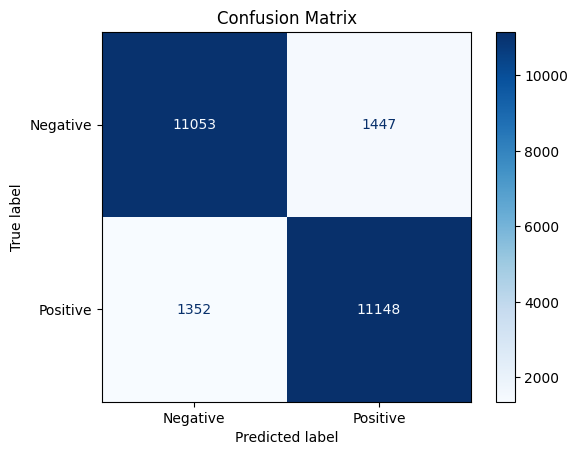

In [ ]:
# Generate predictions
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print("\nClassification Report:")
print(classification_report(tokenized_datasets["test"]["label"], predicted_labels,
                          target_names=["Negative", "Positive"]))

# Confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Error Analysis

In [ ]:
# Inspect misclassified samples
print("\nMisclassified Samples (first 10):")
misclassified_count = 0
for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_datasets["test"]["label"])):
    if pred != label and misclassified_count < 10:
        print(f"\nIndex: {idx}")
        print(f"Predicted: {'Positive' if pred == 1 else 'Negative'}, Actual: {'Positive' if label == 1 else 'Negative'}")
        print(f"Text: {tokenized_datasets['test'][idx]['text'][:200]}...")
        misclassified_count += 1


Misclassified Samples (first 10):

Index: 1
Predicted: Positive, Actual: Negative
Text: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell ...

Index: 4
Predicted: Positive, Actual: Negative
Text: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy thes...

Index: 18
Predicted: Positive, Actual: Negative
Text: Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his mother, (Laura Linney), is ... well, let's just say sh...

Index: 20
Predicted: Positive, Actual: Negative
Text: Low budget horror movie. If you don't raise your expectations too high, you'll probably enjoy this little flick. Beginning and end are 

## 7. Enhanced BERT with Attention Pooling

In [ ]:
# Enhanced BERT with attention pooling
import torch.nn as nn
import torch

class EnhancedBERT(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(EnhancedBERT, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name)
        self.attention = nn.Linear(self.bert.config.hidden_size, 1)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask).last_hidden_state
        weights = torch.softmax(self.attention(outputs), dim=1)
        pooled_output = (weights * outputs).sum(dim=1)
        logits = self.classifier(self.dropout(pooled_output))
        return logits

# Initialize the enhanced model (optional)
# enhanced_model = EnhancedBERT("bert-base-uncased", num_labels=2)

## 8. Model Deployment

### Save Model

In [ ]:
# Save the fine-tuned model
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")
print("Model saved to ./fine_tuned_bert")

Model saved to ./fine_tuned_bert


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

# Calculate and print accuracy, F1 score, and precision
accuracy = accuracy_score(tokenized_datasets["test"]["label"], predicted_labels)
f1 = f1_score(tokenized_datasets["test"]["label"], predicted_labels)
precision = precision_score(tokenized_datasets["test"]["label"], predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.8880
F1 Score: 0.8885
Precision: 0.8851


### Using Hugging Face Pipeline for Inference

In [ ]:
# Quick inference using pipeline
from transformers import pipeline

# Load the model and tokenizer into a pipeline
classifier = pipeline("text-classification", model="./fine_tuned_bert", tokenizer="./fine_tuned_bert")

# Test the pipeline
test_texts = [
    "I loved this movie! It was fantastic.",
    "This was the worst film I've ever seen.",
    "It was okay, nothing special."
]

print("\nInference Results:")
for text in test_texts:
    result = classifier(text)
    print(f"\nText: {text}")
    print(f"Prediction: {result}")

Device set to use cuda:0



Inference Results:

Text: I loved this movie! It was fantastic.
Prediction: [{'label': 'LABEL_1', 'score': 0.9984820485115051}]

Text: This was the worst film I've ever seen.
Prediction: [{'label': 'LABEL_0', 'score': 0.9986982345581055}]

Text: It was okay, nothing special.
Prediction: [{'label': 'LABEL_0', 'score': 0.9978057742118835}]


### FastAPI Deployment Code (Save as separate .py file)

In [ ]:
# FastAPI deployment example (save as app.py and run with: uvicorn app:app --reload)
fastapi_code = '''
from fastapi import FastAPI
from pydantic import BaseModel
from transformers import pipeline

app = FastAPI()

# Load the pipeline
classifier = pipeline("text-classification", model="./fine_tuned_bert")

# Define the input schema
class TextRequest(BaseModel):
    text: str

@app.post("/predict")
def predict(request: TextRequest):
    result = classifier(request.text)
    return {"label": result[0]["label"], "score": result[0]["score"]}

# Run with: uvicorn app:app --reload
'''

print("FastAPI deployment code:")
print(fastapi_code)

FastAPI deployment code:

from fastapi import FastAPI
from pydantic import BaseModel
from transformers import pipeline

app = FastAPI()

# Load the pipeline
classifier = pipeline("text-classification", model="./fine_tuned_bert")

# Define the input schema
class TextRequest(BaseModel):
    text: str

@app.post("/predict")
def predict(request: TextRequest):
    result = classifier(request.text)
    return {"label": result[0]["label"], "score": result[0]["score"]}

# Run with: uvicorn app:app --reload



## 9. Troubleshooting and Optimization

### Check GPU Memory

In [ ]:
# Check GPU memory usage
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

    # Clear cache if needed
    torch.cuda.empty_cache()
    print("GPU cache cleared")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1713 MiB |   2297 MiB | 110846 GiB | 110845 GiB |
|       from large pool |   1711 MiB |   2288 MiB | 104444 GiB | 104443 GiB |
|       from small pool |      2 MiB |     25 MiB |   6402 GiB |   6402 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1713 MiB |   2297 MiB | 110846 GiB | 110845 GiB |
|       from large pool |   1711 MiB |   2288 MiB | 104444 GiB |

### Custom Model with Dropout for Overfitting Prevention

In [ ]:
# Custom model with dropout to prevent overfitting
class CustomModelWithDropout(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomModelWithDropout, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.dropout(output.logits)

# Use this model if experiencing overfitting
# dropout_model = CustomModelWithDropout("bert-base-uncased", num_labels=2)

In [ ]:
# Extract BERT embeddings from a sample of test data
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get embeddings from BERT model
def get_bert_embeddings(texts, model, tokenizer, max_length=128):
    """Extract BERT embeddings for given texts"""
    embeddings = []
    model.eval()

    # Determine the device of the model
    device = model.bert.device

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                             truncation=True, max_length=max_length)
            # Move input tensors to the same device as the model
            inputs = {key: value.to(device) for key, value in inputs.items()}
            outputs = model.bert(**inputs)
            # Use [CLS] token embedding and move back to CPU for numpy conversion
            embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(embedding)

    return np.array(embeddings)

# Sample subset of test data for clustering
sample_size = 1000  # Use larger sample for training
sample_texts = dataset["test"]["text"][:sample_size]
sample_labels = dataset["test"]["label"][:sample_size]

print("Extracting BERT embeddings...")
embeddings = get_bert_embeddings(sample_texts, model, tokenizer)

# Apply K-Means clustering
n_clusters = 2  # Binary classification task
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Calculate clustering accuracy (compare with actual labels)
from sklearn.metrics import adjusted_rand_score, silhouette_score

ari = adjusted_rand_score(sample_labels, cluster_labels)
silhouette = silhouette_score(embeddings, cluster_labels)

print(f"\nK-Means Clustering Results:")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Cluster distribution: {np.bincount(cluster_labels)}")

Extracting BERT embeddings...

K-Means Clustering Results:
Adjusted Rand Index: 0.0000
Silhouette Score: 0.6999
Cluster distribution: [849 151]
